In [1]:
### Load the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import minimize
import pickle

plt.rc('text',usetex=True)
plt.rc('font',family='serif',size=14)

In [2]:
### Load data 

with open('BL_params.pkl', 'rb') as file:
    data = pickle.load(file)

x = data['x'] # streamwise locations, x/d
y = data['y'] # crosswise locations, y/d
u = data['u'] # mean streamwise velocity [m/s] 
U_inf = data['U_inf'] # freestream velocity [m/s]
nu = data['nu'] # viscosity [m^2/s]

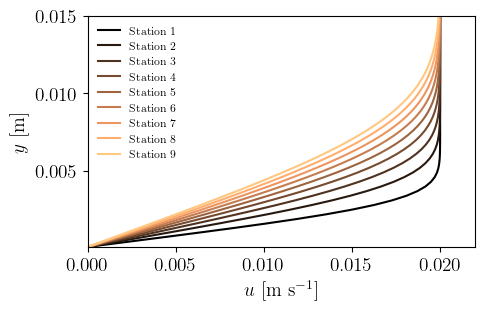

In [3]:
### Plot profiles 

color_map = cm.get_cmap('copper', len(x))

plt.figure(1,figsize=(5,3))
for i in range(len(x)):
    color = color_map(i / (len(x) - 1))
    plt.plot(u[i,:], y[i,:], label=f"Station {i + 1}", color=color)    
    
plt.xlabel(r"$u$ [m s$^{-1}$]")
plt.ylabel(r"$y$ [m]")
plt.xlim([0, 1.1*U_inf])
plt.ylim([np.min(y), 0.015])
plt.legend(frameon=False,fontsize=8, loc='upper left')

plt.show()

In [4]:
### Collapse the profiles

def loss(var, xin, yin):
    vari  = np.reshape(var,(len(x),2))
    xtran = vari[:,0][:,np.newaxis]*xin
    ytran = vari[:,1][:,np.newaxis]*yin
    
    # interpolate at the transformed coordinates grid
    ninterp = np.shape(y)[1]
    llim    = np.max(np.amin(xtran,axis=1))
    ulim    = np.min(np.amax(xtran,axis=1))
    newgr   = np.linspace(llim,ulim,ninterp)
    new_y   = np.zeros((len(x),ninterp))
    for i in range(len(x)):
        new_y[i,:] = np.interp(newgr,xtran[i,:],ytran[i,:])
    
    # compute distances
    dist_mat = np.zeros((len(x),len(x)))
    for i in range(len(x)):
        for j in range(len(x)):
            dist_mat[i,j] = (np.linalg.norm(new_y[i,:] - new_y[j,:]))**2
            
    dist = np.sum(dist_mat)/2.0
    
    return dist

# Define parameters and initialise transformation matrices
varopt = np.ones((2*len(x)))

bounds = np.zeros((2*len(x),2))
bounds[:,0] = 0
bounds[:,1] = None

# Optimisation
res = minimize(loss, varopt, args=(y, u), bounds=bounds)

varm = np.reshape(res.x,(len(x),2))
t1   = varm[:,0]
t2   = varm[:,1]

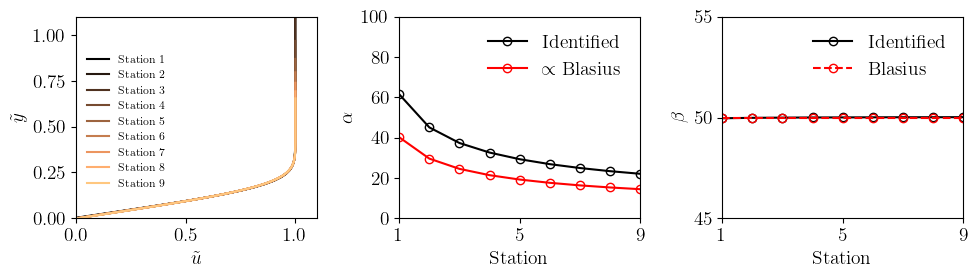

In [5]:
### Normalise and plot data

def normalise(field,transform):    
    fmin = np.average(np.min(field,axis=1))
    fmax = np.average(np.max(field,axis=1))
    f_norm = (field-fmin)/(fmax-fmin)
    t_norm = (transform-fmin)/(fmax-fmin)
    
    return f_norm, t_norm
    
xtran = np.zeros_like(y)
ytran = np.zeros_like(u)
for i in range(len(x)):
    xtran[i,:]=y[i,:]*t1[i]
    ytran[i,:]=u[i,:]*t2[i]
xtran2, t1n = normalise(xtran,t1)
ytran2, t2n = normalise(ytran,t2)

# Plot data
fig, ax = plt.subplots(1,3,figsize=(10,3))

for i in range(len(x)):
    color = color_map(i / (len(x) - 1))
    ax[0].plot(ytran2[i,:],xtran2[i,:], label=f'Station {i + 1}', color=color)
ax[0].legend(frameon=False, fontsize=8, bbox_to_anchor=(0.41, 0.86))
ax[0].set_xlabel(r'$\tilde{u}$')
ax[0].set_ylabel(r'$\tilde{y}$')
ax[0].set_xlim([0.0,1.1])
ax[0].set_ylim([0.0,1.1])

scal = np.sqrt(U_inf/(nu*x))
ax[1].plot(np.arange(len(x))+1,t1n,'-ko',mfc='none', label='Identified')
ax[1].plot(np.arange(len(x))+1,scal/8,'-ro',mfc='none', label='$\propto$ Blasius')
ax[1].set_xlabel(r'Station')
ax[1].set_ylabel(r'$\alpha$')
ax[1].set_xlim([1,9])
ax[1].set_ylim([0.0,100])
ax[1].set_xticks([1,5,9])
ax[1].legend(frameon=False)

ax[2].plot(np.arange(len(x))+1,t2n,'-ko',mfc='none', label='Identified')
ax[2].plot(np.arange(len(x))+1,np.tile(1/U_inf,len(x)),'--ro',mfc='none', label='Blasius')
ax[2].set_xlabel(r'Station')
ax[2].set_ylabel(r'$\beta$')
ax[2].set_xlim([1,9])
ax[2].set_ylim([45,55])
ax[2].set_xticks([1,5,9])
ax[2].set_yticks([45,50,55])
ax[2].legend(frameon=False)

plt.tight_layout()
plt.show()

In [6]:
### Interpret transformations

# Loss function
def loss(var, target, target_dims, A, A_dims, w1):
    f = np.ones((np.size(target)))
    for i in range(np.shape(A)[1]):
        temp = np.power(A[:,i],var[i+1])
        f   = np.multiply(f,temp)
    f = var[0]*f
    f = np.reshape(f,(np.size(f),1)) 
    
    f_dims = np.matmul(A_dims,var[1:])
    f_dims = np.reshape(f_dims,(np.size(f_dims),1)) 

    dist = np.sum((f - target)**2) + w1*np.sum(np.abs(f_dims - target_dims))
    
    return dist

# Interpret first identified transformation (alpha)
Xsr1   = np.array([np.tile(U_inf,len(x)), np.tile(nu,len(x)), x]).T
X_dims = np.array([[1,2,1],[0,0,0],[-1,-1,0]]) ## L, M, T

Ysr1 = 1/t1n.copy()
Ysr1 = np.reshape(Ysr1,(np.size(Ysr1),1))
Y_dims = np.array([[1],[0],[0]]) ## L, M, T

weight_dims = 1e-4

# Run optimisation
niter = 30
fmin  = 1e20
for i in range(niter):
    var = np.ones((np.shape(Xsr1)[1]+1,1)) # adding a multiplitative constant to the power law
    var = var.flatten()*np.random.rand(np.size(var))
    
    res = minimize(loss, var, args=(Ysr1, Y_dims, Xsr1, X_dims, weight_dims))
    if (res.fun < fmin):
        fmin   = res.fun
        var_b1 = res.x

print("The found constant and powers are:", var_b1)
f = np.ones((np.size(Ysr1)))
for i in range(np.shape(Xsr1)[1]):
    temp = np.power(Xsr1[:,i],var_b1[i+1])
    f    = np.multiply(f,temp)
f = var_b1[0]*f
f = np.reshape(f,(np.size(f),1))

f_dims = np.matmul(X_dims,var_b1[1:])
print("The dimensions of the found expression are:", f_dims)

# Interpret second identified transformation (beta)
Xsr2   = np.array([np.tile(U_inf,len(x)), np.tile(nu,len(x)), x]).T
X_dims = np.array([[1,2,1],[0,0,0],[-1,-1,0]]) ## L, M, T

Ysr2   = 1/t2n.copy()
Ysr2   = np.reshape(Ysr2,(np.size(Ysr2),1))
Y_dims = np.array([[1],[0],[-1]]) ## L, M, T

weight_dims = 1e-4

# Run optimisation
niter = 30
fmin  = 1e20
for i in range(niter):
    var = np.ones((np.shape(Xsr2)[1]+1,1)) # adding a multiplitative constant to the power law
    var = var.flatten()*np.random.rand(np.size(var))
   
    res = minimize(loss, var, args=(Ysr2, Y_dims, Xsr2, X_dims, weight_dims))
    if (res.fun < fmin):
        fmin   = res.fun
        var_b2 = res.x

print("The found constant and powers are:", var_b2)
f = np.ones((np.size(Ysr2)))
for i in range(np.shape(Xsr2)[1]):
    temp = np.power(Xsr2[:,i],var_b2[i+1])
    f    = np.multiply(f,temp)
f = var_b2[0]*f
f = np.reshape(f,(np.size(f),1))

f_dims = np.matmul(X_dims,var_b2[1:])
print("The dimensions of the found expression are:", f_dims)

The found constant and powers are: [ 5.28037293 -0.50177919  0.50178839  0.49819435]
The dimensions of the found expression are: [ 9.99991942e-01  0.00000000e+00 -9.20234773e-06]
The found constant and powers are: [ 1.00221689e+00  9.99469502e-01  5.30490187e-04 -5.31610171e-04]
The dimensions of the found expression are: [ 0.99999887  0.         -0.99999999]


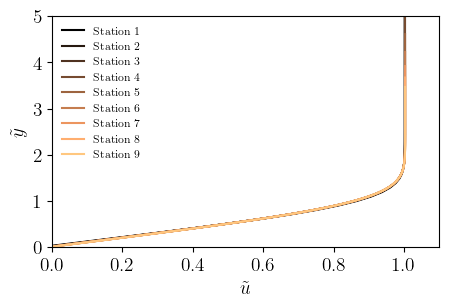

In [7]:
### Plot interpreted collapse 

scaly_new = U_inf**var_b1[1] * nu**var_b1[2] * x**var_b1[3] 
scalu_new = U_inf**var_b2[1] * nu**var_b2[2] * x**var_b2[3] 

y_new = np.zeros((len(x),np.shape(y)[1]))
u_new = np.zeros((len(x),np.shape(y)[1]))
for i in range(np.size(x)):
    y_new[i,:] = y[i,:]/scaly_new[i]
    u_new[i,:] = u[i,:]/scalu_new[i]

plt.figure(1,figsize=(5,3))
for i in range(len(x)):
    color = color_map(i / (len(x) - 1))
    plt.plot(u_new[i,:], y_new[i,:], label=f"Station {i + 1}", color=color)    
    
plt.xlim([0, 1.1])
plt.ylim([0, 5])
plt.legend(frameon=False,fontsize=8, loc='upper left')

plt.xlabel(r'$\tilde{u}$')
plt.ylabel(r'$\tilde{y}$')
plt.show()